# Eksplorasi Data Tempat Wisata Indonesia

Notebook ini berisi ekplorasi data tepat-tempat wisata di Indonesia yang telah dikumpulkan melalui scraping.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import joblib
import os
from collections import Counter

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# NLTK untuk pemrosesan teks dasar
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Sastrawi untuk stemming Bahasa Indonesia
# Pastikan Anda sudah menginstalnya: pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud
import warnings

# Konfigurasi
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 80)

In [2]:
# Download hanya jika belum ada
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

# Inisialisasi stemmer Sastrawi
# Ini dilakukan sekali saja untuk efisiensi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Inisialisasi stop words Bahasa Indonesia
stop_words_indonesian = set(stopwords.words('indonesian'))

In [13]:
# Muat dataset dari file CSV yang diunggah
df = pd.read_csv('../data/tempat_wisata_indonesia.csv')

print(f"Jumlah data awal: {len(df)}")

# Menghapus baris dengan nilai kosong pada kolom-kolom krusial
df.dropna(subset=['alamat', 'jumlah_review', 'rating', 'deskripsi', 'koordinat'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Jumlah data setelah pembersihan awal: {len(df)}")
df.head()

Jumlah data awal: 1169
Jumlah data setelah pembersihan awal: 1167


,id,nama,alamat,rating,jumlah_review,deskripsi,koordinat,url,provinsi,foto,kategori
0,1,Pantai Tebing Lampuuk,"Meunasah Balee, Kec. Lhoknga",4.6,758.000,"Pantai Tebing Lampuuk, yang terletak di Kec. Lhoknga, Aceh Besar, menawarkan...","{'latitude': 5.4970038, 'longitude': 95.227854}",https://www.google.com/maps/place/Pantai+Tebing+Lampuuk/data=!4m7!3m6!1s0x30...,Aceh,data/images/wisata_1.jpg,['pantai']
1,2,Pantai Sawang,"Sawang, Kec. Samudera, Aceh",3.6,31.000,Pantai Sawang atau yang dikenal juga dengan nama Pantai SBB (Sawang Biduak B...,"{'latitude': 5.1545321, 'longitude': 97.2442516}",https://www.google.com/maps/place/Pantai+Sawang/data=!4m7!3m6!1s0x3047854791...,Aceh,data/images/wisata_2.jpg,['pantai']
2,3,Nol Kilometer Kota Banda Aceh,"Gampong Pande, Kec. Kuta Raja, Aceh",4.4,661.000,Tugu Nol Kilometer Kota Banda Aceh adalah sebuah tempat wisata sejarah yang ...,"{'latitude': 5.5826227, 'longitude': 95.3141429}",https://www.google.com/maps/place/Nol+Kilometer+Kota+Banda+Aceh/data=!4m7!3m...,Aceh,data/images/wisata_3.jpg,['lainnya']
3,4,Pantai Ulee Lheue,"Ulee Lheue, Kec. Meuraxa, Aceh",4.5,625.000,Pantai Ulee Lheue di Banda Aceh adalah tempat wisata yang memadukan keindaha...,"{'latitude': 5.5643903, 'longitude': 95.2923091}",https://www.google.com/maps/place/Pantai+Ulee+Lheue/data=!4m7!3m6!1s0x304030...,Aceh,data/images/wisata_4.jpg,['pantai']
4,6,Lapangan Blang Padang,"Kp. Baru, Kec. Baiturrahman",4.5,11.275,Lapangan Blang Padang adalah sebuah ruang terbuka hijau yang terletak di pus...,"{'latitude': 5.5499808, 'longitude': 95.3136744}",https://www.google.com/maps/place/Lapangan+Blang+Padang/data=!4m7!3m6!1s0x30...,Aceh,data/images/wisata_6.jpg,['lapangan']


## 1. Ekplorasi Data Awal

In [14]:
# memeriksa informasi dasar tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1167 non-null   int64  
 1   nama           1167 non-null   object 
 2   alamat         1167 non-null   object 
 3   rating         1167 non-null   float64
 4   jumlah_review  1167 non-null   float64
 5   deskripsi      1167 non-null   object 
 6   koordinat      1167 non-null   object 
 7   url            1167 non-null   object 
 8   provinsi       1167 non-null   object 
 9   foto           1167 non-null   object 
 10  kategori       1167 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 100.4+ KB


In [5]:
# memeriksa data yang hilang (missing value)
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
missing_df.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percentage
id,0,0.0
nama,0,0.0
alamat,0,0.0
rating,0,0.0
jumlah_review,0,0.0
deskripsi,0,0.0
koordinat,0,0.0
url,0,0.0
provinsi,0,0.0
foto,0,0.0


In [15]:
# Menghapus baris dengan missing values pada kolom 'alamat', 'jumlah_review', dan 'rating'
df = df.dropna(subset=['alamat', 'jumlah_review', 'rating'])

In [7]:
# Memeriksa data yang hilang setelah penghapusan
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
print("\nData yang hilang setelah penghapusan:")
print(missing_df.sort_values(by='Missing Values', ascending=False))


Data yang hilang setelah penghapusan:
               Missing Values  Percentage
id                          0         0.0
nama                        0         0.0
alamat                      0         0.0
rating                      0         0.0
jumlah_review               0         0.0
deskripsi                   0         0.0
koordinat                   0         0.0
url                         0         0.0
provinsi                    0         0.0
foto                        0         0.0
kategori                    0         0.0


In [16]:
# Memeriksa jumlah baris setelah penghapusan
print(f"\nJumlah baris setelah penghapusan: {len(df)}")


Jumlah baris setelah penghapusan: 1167


In [9]:
# statistik deskriptif untuk kolom numerik
df.describe() 

,id,rating,jumlah_review
count,1167.000000,1167.000000,1167.000000
mean,585.548415,4.425878,184.203093
std,337.462747,0.236684,240.327863
min,1.000000,3.000000,1.000000
25%,293.500000,4.300000,7.994000
50%,586.000000,4.400000,77.000000
75%,877.500000,4.600000,262.000000
max,1169.000000,5.000000,999.000000


## 2. Ekplorasi Rating dan Jumlah Review

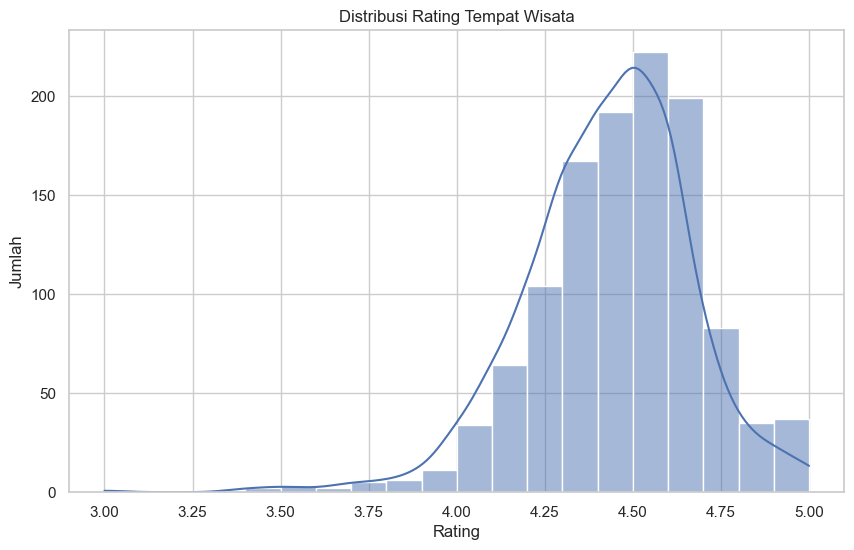

In [17]:
# distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Tempat Wisata')
plt.xlabel('Rating') 
plt.ylabel('Jumlah')
plt.show()

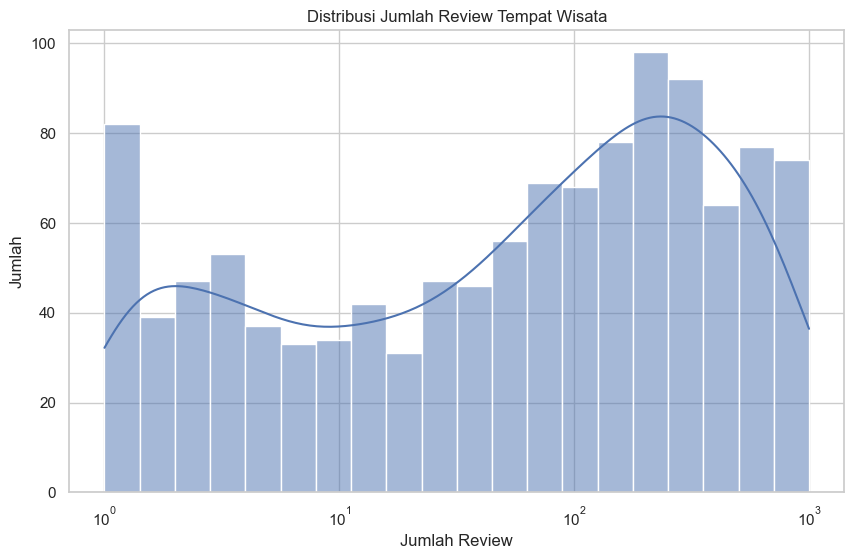

In [11]:
# distribusi jumlah review (dengan skala log)
plt.figure(figsize=(10, 6))
sns.histplot(df['jumlah_review'], bins=20, kde=True, log_scale=True)
plt.title('Distribusi Jumlah Review Tempat Wisata')
plt.xlabel('Jumlah Review')
plt.ylabel('Jumlah')
plt.show() 

## 3. Ekplorasi Kategori Wisata

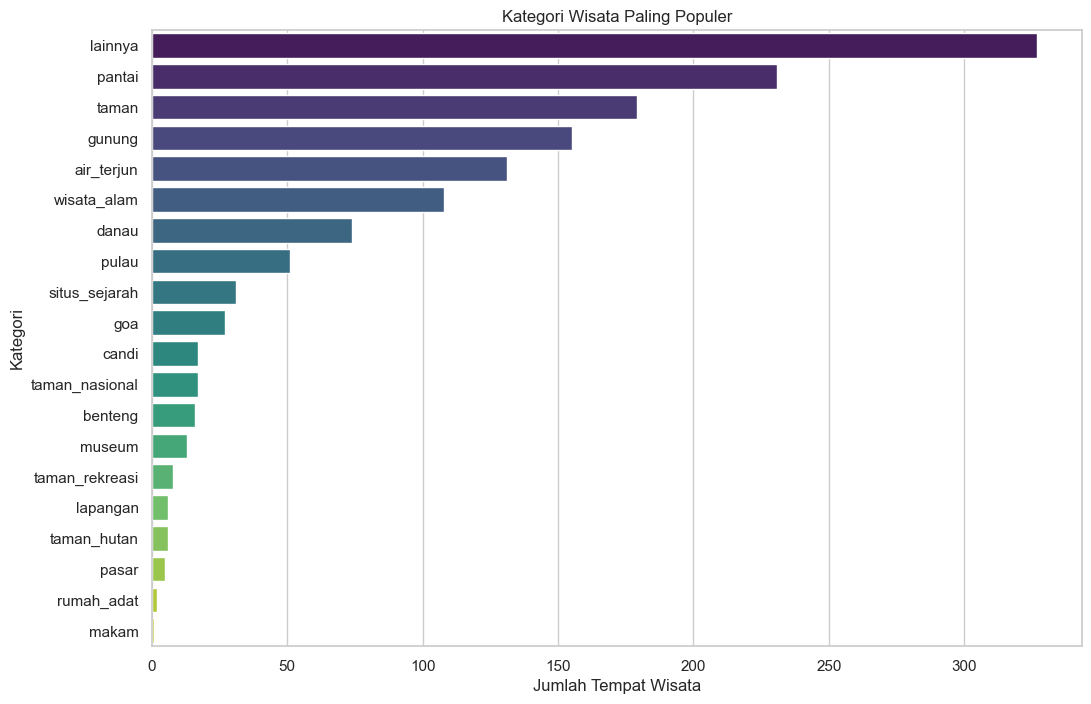

In [18]:
# konversi string kategori menjadi list
df['kategori_list'] = df['kategori'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# hitung frekuensi setiap kategori
all_categories = [category for sublist in df['kategori_list'] for category in sublist]
category_counts = Counter(all_categories)

# buat dataframe untuk visualisasi
category_df = pd.DataFrame({'Category': list(category_counts.keys()), 'Count': list(category_counts.values())})
category_df = category_df.sort_values(by='Count', ascending=False)

# plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Category', data=category_df, palette='viridis')
plt.title('Kategori Wisata Paling Populer')
plt.xlabel('Jumlah Tempat Wisata')
plt.ylabel('Kategori')
plt.show()

## 4. Ekplorasi Berdasarakan Provinsi

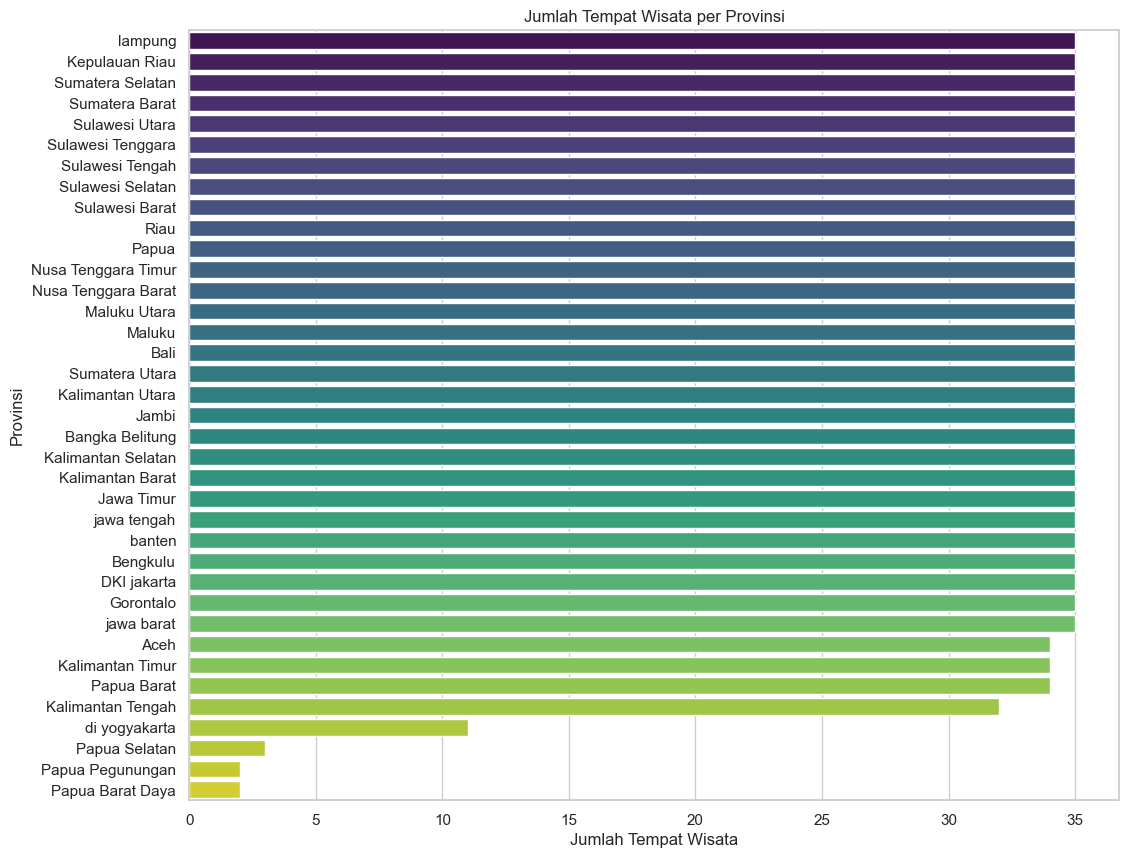

In [19]:
# jumlah tempat wisata per provinsi
provinsi_counts = df['provinsi'].value_counts().reset_index()
provinsi_counts.columns = ['Provinsi', 'Jumlah Tempat Wisata']

# plot bar chart
plt.figure(figsize=(12, 10))
sns.barplot(x='Jumlah Tempat Wisata', y='Provinsi', data=provinsi_counts, palette='viridis')
plt.title('Jumlah Tempat Wisata per Provinsi')
plt.xlabel('Jumlah Tempat Wisata')
plt.ylabel('Provinsi')
plt.show()

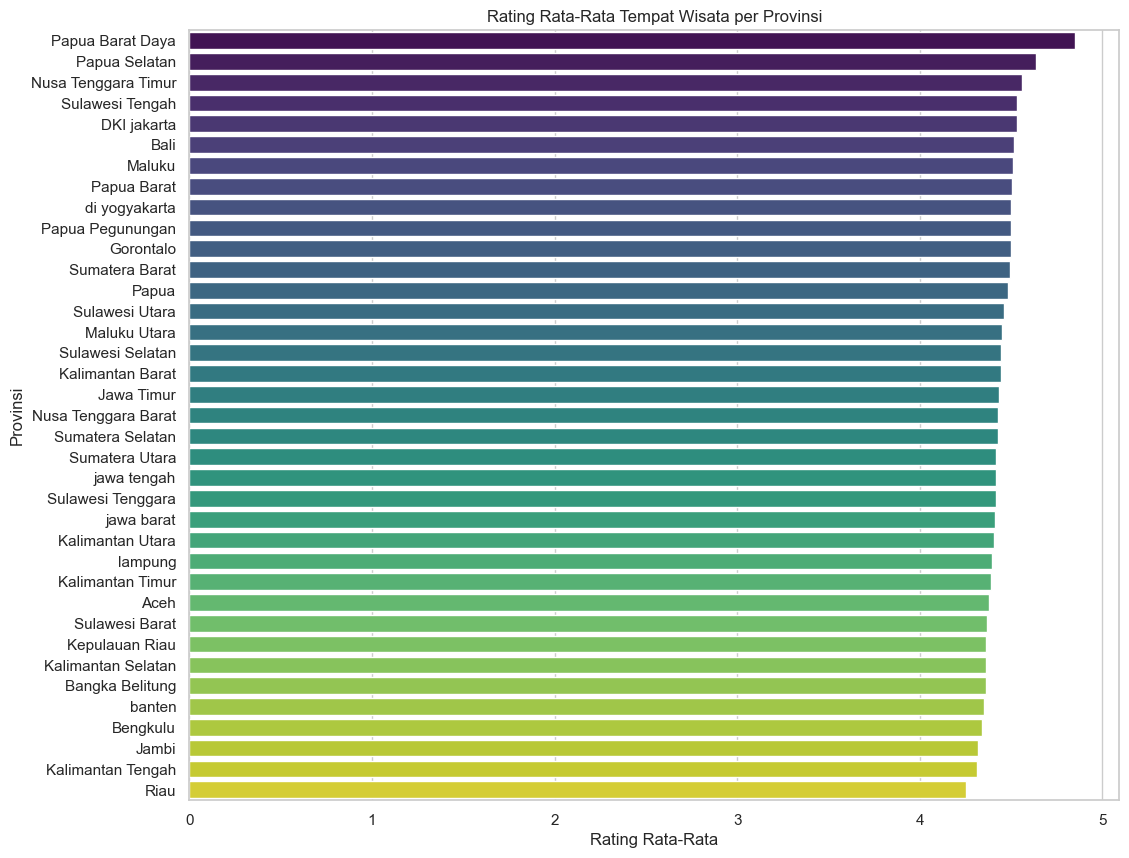

In [20]:
# rating rata-rata per provinsi
rating_provinsi = df.groupby('provinsi')['rating'].mean().reset_index()
rating_provinsi = rating_provinsi.sort_values(by='rating', ascending=False)

# plot bar chart
plt.figure(figsize=(12, 10))
sns.barplot(x='rating', y='provinsi', data=rating_provinsi, palette='viridis')
plt.title('Rating Rata-Rata Tempat Wisata per Provinsi')
plt.xlabel('Rating Rata-Rata')
plt.ylabel('Provinsi')
plt.show()

## 5. Analisis Korelasi

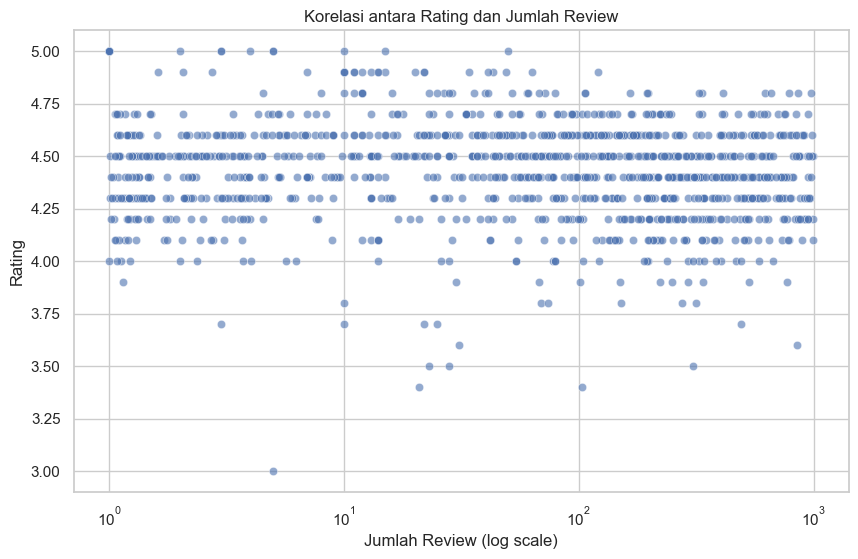

Korelasi antara rating dan jumlah review: -0.11


In [21]:
# korelasi antara rating dan jumlah review
plt.figure(figsize=(10, 6))
sns.scatterplot(x='jumlah_review', y='rating', data=df, alpha=0.6)
plt.title('Korelasi antara Rating dan Jumlah Review')
plt.xlabel('Jumlah Review (log scale)')
plt.ylabel('Rating')
plt.xscale('log')
plt.grid(True)
plt.show()

#hitung korelasi antara rating dan jumlah review
correlation = df['rating'].corr(df['jumlah_review'])
print(f"Korelasi antara rating dan jumlah review: {correlation:.2f}")


## 6. Analisis Teks Deskripsi

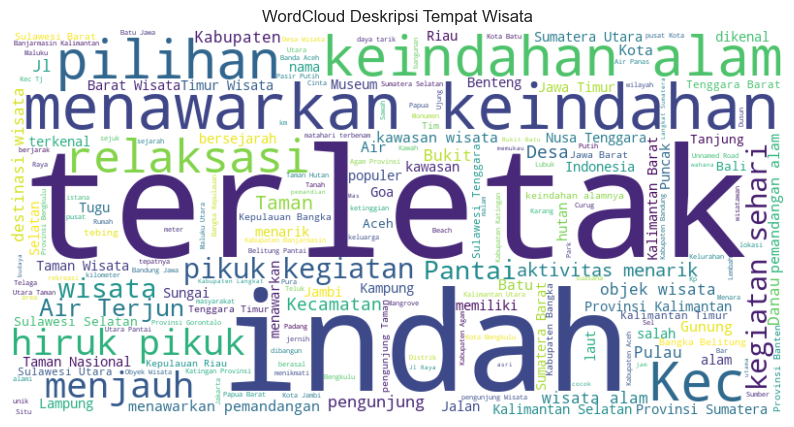

In [22]:
# gabungkan semua deskripsi menjadi satu teks
all_descriptions = ' '.join(df['deskripsi'].dropna().astype(str))

# coba gunakan stopwords indonesia, jika tidak ada gunakan stopwords inggris
try:
    stop_words = set(stopwords.words('indonesian'))
except LookupError:
    stop_words = set(stopwords.words('english'))

# tambahkan stopword kostum
custom_stopwords = ['yang', 'ini', 'dan', 'di', 'dengan', 'untuk', 'dari', 'pada', 'ke', 'adalah']
stop_words.update(custom_stopwords)

# buat wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, max_words=200).generate(all_descriptions)

# tampilkan wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Deskripsi Tempat Wisata')
plt.show()

## 7. Pra-pemrosesan Data untuk Model Rekomendasi 

In [23]:
# fungsi untuk pra-pemrosesan teks
def preprocess_text(text):
    if pd.isna(text):
        return ''
    
    # konversi ke lowercase
    text = text.lower()

    # hapus karakter khusus dan angka
    text = re.sub(r'[^\\w\\s]', ' ', text)
    text = re.sub(r'\\d+', ' ', text)

    # tokenisasi
    tokens = word_tokenize(text)

    # hapus stopwords
    stop_words = set(stopwords.words('indonesian'))     
    tokens = [word for word in tokens if word not in stop_words]

    # stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # gabungkan kembali menjadi satu teks
    return ' '.join(tokens)

In [24]:
# pra-pemrosesan teks pada kolom 'deskripsi'
df['deskripsi_processed'] = df['deskripsi'].apply(preprocess_text)

# konversi kategori dari string ke list
df['kategori_list'] = df['kategori'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# gabungkan kategori menjadi string untuk TF-IDF
df['kategori_string'] = df['kategori_list'].apply(lambda x: ' '.join(x))

# konversi koordinat dari string ke dictionary, lalu ekstrak latitude dan longitude
def extract_coordinates(coord_str):
    if pd.isna(coord_str):
        return np.nan, np.nan
    
    try:
        coord_dict = ast.literal_eval(coord_str) if isinstance(coord_str, str) else coord_str
        return coord_dict.get('latitude', np.nan), coord_dict.get('longitude', np.nan)
    except (ValueError, KeyError):
        return np.nan, np.nan

df['latitude'], df['longitude'] = zip(*df['koordinat'].apply(extract_coordinates))

In [25]:
# cek hasil prepocessing
df[['nama', 'deskripsi', 'deskripsi_processed', 'kategori_list', 'kategori_string', 'latitude', 'longitude']].head()

,nama,deskripsi,deskripsi_processed,kategori_list,kategori_string,latitude,longitude
0,Pantai Tebing Lampuuk,"Pantai Tebing Lampuuk, yang terletak di Kec. Lhoknga, Aceh Besar, menawarkan...",s w w s s s s s s,[pantai],pantai,5.497004,95.227854
1,Pantai Sawang,Pantai Sawang atau yang dikenal juga dengan nama Pantai SBB (Sawang Biduak B...,s w s s w s s s,[pantai],pantai,5.154532,97.244252
2,Nol Kilometer Kota Banda Aceh,Tugu Nol Kilometer Kota Banda Aceh adalah sebuah tempat wisata sejarah yang ...,s w s s w s s,[lainnya],lainnya,5.582623,95.314143
3,Pantai Ulee Lheue,Pantai Ulee Lheue di Banda Aceh adalah tempat wisata yang memadukan keindaha...,w s s w s s,[pantai],pantai,5.564390,95.292309
4,Lapangan Blang Padang,Lapangan Blang Padang adalah sebuah ruang terbuka hijau yang terletak di pus...,s s s s w s w s s s w s s s,[lapangan],lapangan,5.549981,95.313674


## 8. Content-Based Filtering

In [26]:
# membuat fitur kombinasi yang terdiri dari deskripsi, kategori, dan nama lokasi
df['fitur_kombinasi'] = df['deskripsi_processed'] + ' ' + df['kategori_string'] + ' ' + df['provinsi'].str.lower()

# Pastikan stop_words adalah list
stop_words = list(stop_words)  # Konversi set ke list

# terapkan TF-IDF pada fitur kombinasi
tfidf = TfidfVectorizer(stop_words=stop_words)
fitur_tfidf = tfidf.fit_transform(df['fitur_kombinasi'])

print(f"Ukuran matriks TF-IDF: {fitur_tfidf.shape}")


Ukuran matriks TF-IDF: (1167, 52)


In [27]:
# hitung cosine similarity
cosine_sim = cosine_similarity(fitur_tfidf, fitur_tfidf)
print(f"Ukuran matriks cosine similarity: {cosine_sim.shape}")

Ukuran matriks cosine similarity: (1167, 1167)


In [28]:
# buat indeks berdasarkan nama tempat wisata
indices = pd.Series(df.index, index=df['nama']).drop_duplicates()

# fungsi untuk rekomendasi berdasarkan content-based
def content_based_recommendations(name, cosine_sim=cosine_sim, df=df, indices=indices, top_n=10):
    # dapatkan indeks tempat wisata dari namanya
    try:
        idx = indices[name]
    except KeyError:
        return "Tempat wisata tidak ditemukan, coba nama lain"
    
    # dapatkan skor kesamaan untuk semua tempat wisata 
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # urutkan tempat wisata berdasarkan skor kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # dapatkan skor top_n tempat wisata yang paling mirip (kecuali dirinya sendiri)
    sim_scores = sim_scores[1:top_n+1]

    # dapatkan indeks tempat wisata
    attraction_indices = [i[0] for i in sim_scores]

    # kembalikan top_n tempat wisata yang paling mirip
    recommended_place = df.iloc[attraction_indices][['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list']]
    recommended_place['similarity_score'] = [i[1] for i in sim_scores]

    return recommended_place

In [29]:
# contoh rekomendasi content-based
sample_place = df['nama'].iloc[0]
print(f"Rekomendasi untuk: {sample_place} di {df.iloc[0]['provinsi']}")

content_recs = content_based_recommendations(sample_place)
content_recs


Rekomendasi untuk: Pantai Tebing Lampuuk di Aceh


,nama,provinsi,rating,jumlah_review,kategori_list,similarity_score
1,Pantai Sawang,Aceh,3.6,31.000,[pantai],1.000000
3,Pantai Ulee Lheue,Aceh,4.5,625.000,[pantai],1.000000
13,Pantai Paradiso Sabang,Aceh,4.5,421.000,[pantai],1.000000
20,Pantai Ujong Batee,Aceh,4.1,580.000,[pantai],1.000000
22,Pantai Penyu,Aceh,4.3,583.000,[pantai],1.000000
29,Ujoeng Pancu Beach,Aceh,4.5,284.000,[pantai],1.000000
33,Pantai Ulee Lheue,Aceh,4.4,3.743,[pantai],1.000000
2,Nol Kilometer Kota Banda Aceh,Aceh,4.4,661.000,[lainnya],0.864878
10,Anjong Mon Mata Banda Aceh,Aceh,4.4,411.000,[lainnya],0.864878
14,Mon Ceunong,Aceh,4.6,89.000,[lainnya],0.864878


## 9. Popularity-Based Filtering

In [30]:
# kombinasi rating dan jumlah review  untuk mendapatkan score popularitas
# gunakan weight rating formula: WR = (v/(v+m)) + R + (m/(v+m)) * C
# dimana:
# v = jumlah review untuk tempat wisata
# m = jumlah review minimum untuk dipertimbangkan (kita akan menggunakan persentil ke-90)
# R = rating untuk tempat wisata
# C = rating rata-rata untuk seluruh dataset

# buat salinan dataframe untuk menyimpan hasil
df_popular = df.copy()

# hitung parameter
C = df_popular['rating'].mean()
m = df_popular['jumlah_review'].quantile(0.90)

print(f"rating rata-rata: {C:.2f}")
print(f"jumlah review minimum: {m:.0f}")




rating rata-rata: 4.43
jumlah review minimum: 559


In [31]:
# fungsi untuk menghitung weight rating
def weight_rating(x, m=m, C=C):
    v = x['jumlah_review']
    R = x['rating']
    return (v/(v+m)) * R + (m/(v+m)) * C


In [32]:
# hitung weight rating
df_popular['score_popularitas'] = df_popular.apply(weight_rating, axis=1)

# urutkan berdasarkan score popularitas
df_popular = df_popular.sort_values(by='score_popularitas', ascending=False)

# tampilkan 10 tempat wisata dengan score popularitas tertinggi
df_popular[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'score_popularitas']].head(10)


,nama,provinsi,rating,jumlah_review,kategori_list,score_popularitas
71,Pulau Kelayang,Bangka Belitung,4.8,978.0,[pulau],4.663934
110,Gua Maria Bukit Kanada,banten,4.8,858.0,"[gunung, goa, wisata_alam]",4.652411
178,Kraton Jogja,di yogyakarta,4.8,785.0,[lainnya],4.644394
969,Danau Paisu Pok Luk Panenteng,Sulawesi Tengah,4.8,656.0,[danau],4.627873
768,Air Terjun Tanggedu,Nusa Tenggara Timur,4.8,620.0,"[air_terjun, wisata_alam]",4.622617
107,Wisata Kampung Marengo Baduy Luar,banten,4.7,951.0,[lainnya],4.598521
240,Taman Laut Olele,Gorontalo,4.7,843.0,"[pantai, taman]",4.590703
616,Wihara Thay Hin Bio,lampung,4.8,413.0,[lainnya],4.584842
967,Air Terjun Saluopa,Sulawesi Tengah,4.7,753.0,[air_terjun],4.583206
735,Taman Wisata Pusuk Sembalun (Tourist Park),Nusa Tenggara Barat,4.7,750.0,[taman],4.582938


In [33]:
# fungsi mendapatkan rekomendasi popularity-based berdasarkan kategori
def popularity_based_recommendation(category=None, provinsi=None, df=df_popular, top_n=10):
    filtered_df = df.copy()

    # filter berdasarkan kategori jika diberikan
    if category:
        filtered_df = filtered_df[filtered_df['kategori_list'].apply(lambda x: category in x)]

    # filter berdasarkan provinsi jika diberikan
    if provinsi:
        filtered_df = filtered_df[filtered_df['provinsi'] == provinsi]

    # jika tidak ada hasil yang ditemukan setelah filtering
    if filtered_df.empty:
        return "Tidak ada tempat wisata yang cocok dengan kriteria tersebut"
    
    # urutkan berdasarkan score popularitas
    filtered_df = filtered_df.sort_values(by='score_popularitas', ascending=False)

    # kembalikan top_n tempat wisata yang paling populer
    return filtered_df[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'score_popularitas']].head(top_n)
    

In [34]:
# contoh rekomendasi popularity-based untuk kategori 'pantai'
print("Rekomendasi tempat wisata 'pantai' terpopuler:")
popularity_based_recommendation(category='pantai')


Rekomendasi tempat wisata 'pantai' terpopuler:


,nama,provinsi,rating,jumlah_review,kategori_list,score_popularitas
240,Taman Laut Olele,Gorontalo,4.7,843.0,"[pantai, taman]",4.590703
757,Pantai Liman,Nusa Tenggara Timur,4.8,334.0,[pantai],4.565807
1091,Pulau Pasumpahan,Sumatera Barat,4.6,900.0,"[pantai, pulau]",4.533287
460,Taman Hutan Raya Sultan Adam,Kalimantan Selatan,4.6,897.0,"[pantai, taman, taman_hutan]",4.533150
0,Pantai Tebing Lampuuk,Aceh,4.6,758.0,[pantai],4.526094
1059,Pantai Jiko / Patokan,Sulawesi Utara,4.6,603.0,[pantai],4.516236
673,Pantai Falajawa,Maluku Utara,4.6,559.0,[pantai],4.512939
509,Teluk Sulaiman,Kalimantan Timur,4.6,453.0,[pantai],4.503820
753,Pantai Tarimbang,Nusa Tenggara Timur,4.7,167.0,[pantai],4.488934
790,Teluk Triton Kaimana,Papua,4.8,106.0,[pantai],4.485513


In [35]:
# contoh rekomendasi popularity-based untuk provinsi 'Bali'
print("Rekomendasi tempat wisata terpopuler di 'Bali':")
popularity_based_recommendation(provinsi='Bali')


Rekomendasi tempat wisata terpopuler di 'Bali':


,nama,provinsi,rating,jumlah_review,kategori_list,score_popularitas
46,Wisata Edukasi Subak Teba Majalangu,Bali,4.7,415.000,[lainnya],4.542676
47,Kawasan Pariwisata Nusa Dua,Bali,4.6,199.000,[lainnya],4.471591
42,Pantai Biaung,Bali,4.6,185.000,[pantai],4.469175
57,Tanah Lot,Bali,4.7,97.528,"[pantai, candi, pulau]",4.466599
64,Objek Wisata Sangeh,Bali,4.6,158.000,[lainnya],4.464248
34,Desa Coklat Bali,Bali,4.5,253.000,[lainnya],4.448973
51,Desa Wisata Penglipuran,Bali,4.8,26.805,[candi],4.442997
61,Pura Ulun Danu Beratan Bedugul,Bali,4.6,45.864,[candi],4.439081
56,Mandala Suci Wenara Wana,Bali,4.5,51.215,[lainnya],4.432099
68,Tirta Gangga,Bali,4.6,20.511,"[gunung, taman, pulau]",4.432041


## 10. Location-Based Filtering

In [36]:
# defenisikan fungsi untuk menghitung jarak menggunakan rumus haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    # konversi derajat ke radian
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # rumus haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # jari-jari bumi dalam km
    return c * r

In [37]:
# fungsi untuk mendapatkan rekomendasi location-based
def location_based_recommendation(lat, lon, max_distance=50, df=df, top_n=10):
    # hapus baris dengan koordinat nan
    filtered_df = df.dropna(subset=['latitude', 'longitude']).copy()

    # hitung jarak untuk setiap tempat wisata
    filtered_df['distance'] = filtered_df.apply(lambda row: haversine_distance(lat, lon, row['latitude'], row['longitude']), axis=1)

    # Filter tempat wisata dalam radius max_distance
    # filtered_df = filtered_df[filtered_df['distance'] <= max_distance]
    filtered_df = filtered_df.sort_values('distance')

    # jika tidak ada hasil yang ditemukan
    if filtered_df.empty:
        return f"tidak ada tempat wisata dalam radius {max_distance} km dari lokasi tersebut"
    
    # urutkan berdasarkan jarak
    filtered_df = filtered_df.sort_values('distance')

    # kembalikan top_n tempat wisata terdekat
    return filtered_df[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'distance']].head(top_n)

In [38]:
# contoh rekomendasi location-based
# misalnya, kita menggunakan koordinat Jakarta: -6.2088, 106.8456
print("rekomendasi tempat wisata di sekitar jakarta:")
location_based_recommendation(lat=-6.2088, lon=106.8456)

rekomendasi tempat wisata di sekitar jakarta:


,nama,provinsi,rating,jumlah_review,kategori_list,distance
196,Taman Tangkuban Perahu,DKI jakarta,4.5,4.475,[taman],1.151908
197,Taman Suropati,DKI jakarta,4.6,21.656,"[taman, lapangan]",1.774861
206,Taman Situ Lembang,DKI jakarta,4.6,6.565,"[danau, taman, wisata_alam]",1.777922
188,Taman Kodok Menteng,DKI jakarta,4.5,997.000,[taman],2.152808
185,Taman Menteng,DKI jakarta,4.5,20.726,"[taman, lapangan, wisata_alam]",2.267372
214,Taman Pandang Istana,DKI jakarta,4.5,2.484,[taman],4.756816
199,HOLEO Golf & Museum,DKI jakarta,4.9,1.622,[museum],5.147743
217,Pusat Wisata Kuliner JTS keMAYORAn,DKI jakarta,4.5,315.000,[lainnya],5.431733
218,Taman Ria Rio Jakarta,DKI jakarta,4.4,2.058,[taman],5.517670
209,Taman Mataram Jakarta,DKI jakarta,4.6,3.468,[taman],5.749727


## 11. Hybrid Recommendation System

In [39]:
# fungsi untuk hybrid recommendation
def hybrid_recommendation(name=None, lat=None, lon=None, category=None, provinsi=None, max_distance=50, top_n=10):
    results = pd.DataFrame()

    # content-based jika nama tempat diberikan
    if name:
        content_recs = content_based_recommendations(name=name, top_n=top_n*2)
        if isinstance(content_recs, str):
            print(content_recs)
        else:
            results = pd.concat([results, content_recs])

    # location-based jika koordinat diberikan
    if lat is not None and lon is not None:
        location_recs = location_based_recommendation(lat=lat, lon=lon, max_distance=max_distance, top_n=top_n*2)
        if isinstance(location_recs, str):
            print(location_recs)
        else:
            # tambahkan skor jarak yang dinormalisasikan (semakin dekat semakin tinggi skor)
            max_dist = location_recs['distance'].max() if not location_recs.empty else 1
            location_recs['distance_score'] = 1 - (location_recs['distance'] / max_dist)
            results = pd.concat([results, location_recs])

    # popularity-based berdasarkan kategori dan/atau provinsi
    popularity_recs = popularity_based_recommendation(category=category, provinsi=provinsi, top_n=top_n*2)
    if isinstance(popularity_recs, str):
        print(popularity_recs)
    else:
        # results = pd.concat([results, popularity_recs])
        # Hitung jarak untuk tempat wisata di popularity_recs jika lat dan lon diberikan
        if lat is not None and lon is not None:
            popularity_recs = popularity_recs.merge(
                df[['nama', 'latitude', 'longitude']], on='nama', how='left'
            )
            popularity_recs['distance'] = popularity_recs.apply(
                lambda row: haversine_distance(lat, lon, row['latitude'], row['longitude'])
                if pd.notna(row['latitude']) and pd.notna(row['longitude']) else np.nan,
                axis=1
            )
            max_dist = popularity_recs['distance'].max() if not popularity_recs['distance'].isna().all() else 1
            popularity_recs['distance_score'] = 1 - (popularity_recs['distance'] / max_dist)
            popularity_recs = popularity_recs.drop(columns=['latitude', 'longitude'])
        results = pd.concat([results, popularity_recs])

    # jika tidak ada hasil
    if results.empty:
        return f"tidak ada rekomendasi yang sesuai dengan kriteria tersebut"
    
    # normalkan semua skor ke range 0-1
    scaler = MinMaxScaler()
    if 'similarity_score' in results.columns:
        results['similarity_score'] = results['similarity_score'].fillna(0)
        results['similarity_score_normalized'] = scaler.fit_transform(results[['similarity_score']])
    else:
        results['similarity_score_normalized'] = 0
        
    if 'distance_score' in results.columns:
        results['distance_score'] = results['distance_score'].fillna(0)
        results['distance_score_normalized'] = scaler.fit_transform(results[['distance_score']])
    else:
        results['distance_score_normalized'] = 0
        
    if 'score_popularitas' in results.columns:
        results['score_popularitas'] = results['score_popularitas'].fillna(0)
        results['score_popularitas_normalized'] = scaler.fit_transform(results[['score_popularitas']])
    else:
        results['score_popularitas_normalized'] = 0
    
    # Hitung hybrid score dengan bobot berbeda untuk setiap komponen
    results['hybrid_score'] = (
        0.4 * results['similarity_score_normalized'] + 
        0.3 * results['distance_score_normalized'] + 
        0.3 * results['score_popularitas_normalized']
    )
    
    # Hapus duplikat berdasarkan nama
    results = results.drop_duplicates(subset=['nama'])
    
    # Urutkan berdasarkan hybrid score
    results = results.sort_values('hybrid_score', ascending=False)
    
    # Pilih kolom-kolom yang ingin ditampilkan
    display_columns = ['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'hybrid_score']
    if 'distance' in results.columns:
        display_columns.insert(5, 'distance')
    
    # Kembalikan top_n rekomendasi
    return results[display_columns].head(top_n)
        

In [40]:
# Contoh hybrid recommendation berdasarkan nama tempat wisata dan kategori\n",
sample_place = df['nama'].iloc[10]
print(f"Hybrid recommendations untuk {sample_place} dengan kategori 'pantai':")
hybrid_recommendation(name=sample_place, category='pantai')

Hybrid recommendations untuk Anjong Mon Mata Banda Aceh dengan kategori 'pantai':


,nama,provinsi,rating,jumlah_review,kategori_list,hybrid_score
10,Anjong Mon Mata Banda Aceh,Aceh,4.4,411.000,[lainnya],0.400000
16,"Desa Wisata Nusa, Aceh",Aceh,4.6,127.000,[lainnya],0.400000
19,Menara Merah Putih,Aceh,4.6,849.000,[lainnya],0.400000
24,Rumah Cut Nyak Dhien,Aceh,4.6,1.196,[lainnya],0.400000
25,Pucok Krueng,Aceh,4.5,259.000,[lainnya],0.400000
27,Hutan Kota BNI,Aceh,4.3,956.000,[lainnya],0.400000
14,Mon Ceunong,Aceh,4.6,89.000,[lainnya],0.400000
20,Pantai Ujong Batee,Aceh,4.1,580.000,[pantai],0.345951
29,Ujoeng Pancu Beach,Aceh,4.5,284.000,[pantai],0.345951
22,Pantai Penyu,Aceh,4.3,583.000,[pantai],0.345951


In [41]:
# Contoh hybrid recommendation berdasarkan lokasi dan provinsi\n",
print("Hybrid recommendations untuk lokasi di sekitar Bali dengan koordinat -8.4088, 115.1888:")
hybrid_recommendation(lat=-8.4088, lon=115.1888, provinsi='Bali')

Hybrid recommendations untuk lokasi di sekitar Bali dengan koordinat -8.4088, 115.1888:


,nama,provinsi,rating,jumlah_review,kategori_list,distance,hybrid_score
3,Tanah Lot,Bali,4.7,97.528,"[pantai, candi, pulau]",26.147073,0.421880
0,Wisata Edukasi Subak Teba Majalangu,Bali,4.7,415.000,[lainnya],27.225390,0.419281
2,Pantai Biaung,Bali,4.6,185.000,[pantai],28.576741,0.404872
11,Monumen Bajra Sandhi,Bali,4.6,15.163,"[situs_sejarah, lapangan, pasar]",29.654675,0.394695
16,Patung Satria Gatot Kaca,Bali,4.6,4.153,[lainnya],37.331683,0.340199
1,Kawasan Pariwisata Nusa Dua,Bali,4.6,199.000,[lainnya],44.096309,0.295306
9,Tirta Gangga,Bali,4.6,20.511,"[gunung, taman, pulau]",43.835509,0.294538
34,Desa Coklat Bali,Bali,4.5,253.000,[lainnya],1.664647,0.290921
36,Secret Garden Village,Bali,4.6,5.288,[taman],4.053332,0.261005
65,Air Terjun Leke Leke,Bali,4.5,2.808,[air_terjun],4.796103,0.251703


## 12. Simpan Model

In [42]:
# Simpan data dan model yang diperlukan\n",
model_data = {
    'df': df,
    'df_popular': df_popular,
    'cosine_sim': cosine_sim,
    'indices': indices,
    'tfidf_vectorizer': tfidf,
    'C': C,
    'm': m
}

# Buat direktori untuk menyimpan model jika belum ada \n",
os.makedirs('../models', exist_ok=True)

# Simpan model dalam format joblib
joblib.dump(model_data, '../models/recommendation_model.joblib')
print("Model berhasil disimpan di ../models/recommendation_model.joblib")

Model berhasil disimpan di ../models/recommendation_model.joblib


## 13. Pengujian: Load Model dan Buat Rekomendasi

In [43]:
# Load model\n",
loaded_model = joblib.load('../models/recommendation_model.joblib')

# Ekstrak komponen model
loaded_df = loaded_model['df']
loaded_df_popular = loaded_model['df_popular']
loaded_cosine_sim = loaded_model['cosine_sim']
loaded_indices = loaded_model['indices']
loaded_C = loaded_model['C']
loaded_m = loaded_model['m']

print("Model berhasil dimuat.")
print(f"Jumlah data: {len(loaded_df)}")

Model berhasil dimuat.
Jumlah data: 1167


In [44]:
# Definisikan fungsi rekomendasi dengan model yang dimuat\n",
def get_recommendations(name=None, lat=None, lon=None, category=None, province=None, top_n=5):
    # Rekomendasi content-based jika nama tempat wisata diberikan\n",
    if name:
        print(f"\nRekomendasi untuk '{name}':")
        try:
            idx = loaded_indices[name]
            sim_scores = list(enumerate(loaded_cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:top_n+1]
            attraction_indices = [i[0] for i in sim_scores]
            recommendations = loaded_df.iloc[attraction_indices][['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list']]
            print(recommendations)
        except KeyError:
            print(f"Tempat wisata '{name}' tidak ditemukan.")

    # Rekomendasi berdasarkan kategori/provinsi (popularity-based)\n",
    if category or province:
        filter_text = ""
        if category and province:
            filter_text = f"kategori '{category}' di provinsi '{province}'"
        elif category:
            filter_text = f"kategori '{category}'"
        elif province:
            filter_text = f"provinsi '{province}'"
            
        print(f"\nRekomendasi populer untuk {filter_text}:")
        filtered_df = loaded_df_popular.copy()
        
        if category:
            filtered_df = filtered_df[filtered_df['kategori_list'].apply(lambda x: category in x)]
        
        if province:
            filtered_df = filtered_df[filtered_df['provinsi'] == province]
        
        if filtered_df.empty:
            print(f"Tidak ada tempat wisata untuk {filter_text}.")
        else:
            recommendations = filtered_df.sort_values('score_popularitas', ascending=False)
            print(recommendations[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list']].head(top_n))

    # Rekomendasi berdasarkan lokasi\n",
    if lat is not None and lon is not None:
        print(f"\nRekomendasi berdasarkan lokasi ({lat}, {lon}):")
        filtered_df = loaded_df.dropna(subset=['latitude', 'longitude']).copy()
        
        # Hitung jarak
        filtered_df['distance'] = filtered_df.apply(
            lambda row: haversine_distance(lat, lon, row['latitude'], row['longitude']), axis=1)
        
        # Filter dalam radius 50 km
        filtered_df = filtered_df[filtered_df['distance'] <= 50]
        
        if filtered_df.empty:
            print("Tidak ada tempat wisata dalam radius 50 km.")
        else:
            recommendations = filtered_df.sort_values('distance')
            print(recommendations[['nama', 'provinsi', 'rating', 'jumlah_review', 'kategori_list', 'distance']].head(top_n))

In [45]:
# Pengujian rekomendasi dengan model yang telah dimuat\n",
sample_place = loaded_df['nama'].iloc[25]
get_recommendations(name=sample_place, category='pantai', province='Bali')


Rekomendasi untuk 'Pucok Krueng':
                          nama provinsi  rating  jumlah_review kategori_list
10  Anjong Mon Mata Banda Aceh     Aceh     4.4        411.000     [lainnya]
14                 Mon Ceunong     Aceh     4.6         89.000     [lainnya]
16      Desa Wisata Nusa, Aceh     Aceh     4.6        127.000     [lainnya]
19          Menara Merah Putih     Aceh     4.6        849.000     [lainnya]
24        Rumah Cut Nyak Dhien     Aceh     4.6          1.196     [lainnya]

Rekomendasi populer untuk kategori 'pantai' di provinsi 'Bali':
                nama provinsi  rating  jumlah_review           kategori_list
42     Pantai Biaung     Bali     4.6        185.000                [pantai]
57         Tanah Lot     Bali     4.7         97.528  [pantai, candi, pulau]
41  Pura Geger Beach     Bali     4.7          1.281         [pantai, candi]
